In [ ]:
# Upgrade numpy to atleast version 2.x.x - otherwise conflicts occur!

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from transformer_lens import HookedTransformer, utils
from transformer_lens.hook_points import HookPoint
from typing import Dict, List, Tuple, Callable, Optional, Union
from dataclasses import dataclass
from collections import defaultdict
from tqdm.auto import tqdm

import networkx as nx
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage


torch.manual_seed(42)
np.random.seed(42)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'✓ Device: {device}')
print(f'✓ PyTorch version: {torch.__version__}')


sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print('\n✓ All imports successful')

✓ Device: cuda
✓ PyTorch version: 2.8.0+cu126

✓ All imports successful


## 📁 Load Data & Model

In [ ]:

print('Loading corpus...')

try:
    with open('bartleby.txt', 'r', encoding='utf-8') as f:
        bartleby_original = f.read()
    print(f'✓ Loaded bartleby.txt: {len(bartleby_original):,} characters')
except FileNotFoundError:
    print('❌ bartleby.txt not found!')
    print('Please upload bartleby.txt to Colab')
    bartleby_original = None

try:
    with open('bartleby_ai_generated.txt', 'r', encoding='utf-8') as f:
        bartleby_ai = f.read()
    print(f'✓ Loaded bartleby_ai_generated.txt: {len(bartleby_ai):,} characters')
except FileNotFoundError:
    print('❌ bartleby_ai_generated.txt not found!')
    print('Please upload bartleby_ai_generated.txt to Colab')
    bartleby_ai = None

Loading corpus...
✓ Loaded bartleby.txt: 213,893 characters
✓ Loaded bartleby_ai_generated.txt: 45,535 characters


In [ ]:

def chunk_text(text, chunk_size=512, overlap=128):
    """Split text into overlapping chunks for analysis."""
    words = text.split()
    chunks = []

    for i in range(0, len(words), chunk_size - overlap):
        chunk = ' '.join(words[i:i + chunk_size])
        if len(chunk.split()) > 50:
            chunks.append(chunk)

    return chunks

if bartleby_original:
    original_chunks = chunk_text(bartleby_original, chunk_size=512, overlap=128)
    print(f'\n✓ Original text: {len(original_chunks)} chunks')

if bartleby_ai:
    ai_chunks = chunk_text(bartleby_ai, chunk_size=512, overlap=128)
    print(f'✓ AI text: {len(ai_chunks)} chunks')

# AVOID OOM!!!!!
sample_size = min(100, len(original_chunks) if bartleby_original else 0)
original_sample = original_chunks[:sample_size] if bartleby_original else []
ai_sample = ai_chunks[:sample_size] if bartleby_ai else []

print(f'\n✓ Using {sample_size} chunks per category for analysis')


✓ Original text: 98 chunks
✓ AI text: 21 chunks

✓ Using 98 chunks per category for analysis


In [ ]:

print('Loading GPT-2 Medium (355M params)...')
print('This may take 2-3 minutes...')

model = HookedTransformer.from_pretrained(
    'gpt2-medium',
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    device=device,
)

model.eval()

print(f'\n✓ Model loaded!')
print(f'  Layers: {model.cfg.n_layers}')
print(f'  Heads: {model.cfg.n_heads}')
print(f'  d_model: {model.cfg.d_model}')
print(f'  d_mlp: {model.cfg.d_mlp}')
print(f'  Vocab size: {model.cfg.d_vocab:,}')
print(f'  Total params: ~355M')

Loading GPT-2 Medium (355M params)...
This may take 2-3 minutes...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-medium into HookedTransformer

✓ Model loaded!
  Layers: 24
  Heads: 16
  d_model: 1024
  d_mlp: 4096
  Vocab size: 50,257
  Total params: ~355M


## 🧠 Part 1: Large-Scale Activation Extraction

In [ ]:
# Activation extraction utilities
class ActivationExtractor:
    """Extract and cache activations from model."""

    def __init__(self, model, layers='all', max_length=512):
        self.model = model
        self.max_length = max_length

        if layers == 'all':
            self.layers = list(range(model.cfg.n_layers))
        else:
            self.layers = layers

    def extract_mlp_activations(self, text, layer):

        max_chars = self.max_length * 4
        if len(text) > max_chars:
            text = text[:max_chars]

        tokens = self.model.to_tokens(text, prepend_bos=True)

        if tokens.shape[1] > self.max_length:
            tokens = tokens[:, :self.max_length]

        with torch.no_grad():
            _, cache = self.model.run_with_cache(tokens)

        mlp_acts = cache[f'blocks.{layer}.mlp.hook_post']
        return mlp_acts[0]

    def extract_attention_pattern(self, text, layer):
        max_chars = self.max_length * 4
        if len(text) > max_chars:
            text = text[:max_chars]

        tokens = self.model.to_tokens(text, prepend_bos=True)
        if tokens.shape[1] > self.max_length:
            tokens = tokens[:, :self.max_length]

        with torch.no_grad():
            _, cache = self.model.run_with_cache(tokens)

        attn = cache[f'blocks.{layer}.attn.hook_pattern']
        return attn[0]

    def extract_residual_stream(self, text, layer):
        max_chars = self.max_length * 4
        if len(text) > max_chars:
            text = text[:max_chars]

        tokens = self.model.to_tokens(text, prepend_bos=True)
        if tokens.shape[1] > self.max_length:
            tokens = tokens[:, :self.max_length]

        with torch.no_grad():
            _, cache = self.model.run_with_cache(tokens)

        resid = cache[f'blocks.{layer}.hook_resid_post']
        return resid[0]  # [seq_len, d_model]

    def batch_extract_mlp(self, texts, layer, desc='Extracting'):
        """Extract MLP activations for multiple texts."""
        all_acts = []

        for text in tqdm(texts, desc=desc):
            try:
                acts = self.extract_mlp_activations(text, layer)
                if acts.shape[0] > 0:
                    all_acts.append(acts)
            except Exception as e:
                print(f'Skipping chunk due to error: {e}')
                continue

        return all_acts

extractor = ActivationExtractor(model, layers='all')
print('✓ ActivationExtractor initialized')

✓ ActivationExtractor initialized


In [ ]:

target_layers = list(range(16, 24))

print(f'Extracting activations for layers {target_layers}...')
print('This will take ~10-15 minutes...\n')

original_activations = {}
ai_activations = {}

for layer in target_layers:
    print(f'\nLayer {layer}:')

    orig_acts = extractor.batch_extract_mlp(
        original_sample, layer, desc=f'  Original L{layer}'
    )
    original_activations[layer] = orig_acts

    ai_acts = extractor.batch_extract_mlp(
        ai_sample, layer, desc=f'  AI L{layer}'
    )
    ai_activations[layer] = ai_acts

    print(f'  ✓ Layer {layer}: {len(orig_acts)} original, {len(ai_acts)} AI chunks')

print('\n✓ Activation extraction complete!')

Extracting activations for layers [16, 17, 18, 19, 20, 21, 22, 23]...
This will take ~10-15 minutes...


Layer 16:


  Original L16:   0%|          | 0/98 [00:00<?, ?it/s]

  AI L16:   0%|          | 0/21 [00:00<?, ?it/s]

  ✓ Layer 16: 98 original, 21 AI chunks

Layer 17:


  Original L17:   0%|          | 0/98 [00:00<?, ?it/s]

  AI L17:   0%|          | 0/21 [00:00<?, ?it/s]

  ✓ Layer 17: 98 original, 21 AI chunks

Layer 18:


  Original L18:   0%|          | 0/98 [00:00<?, ?it/s]

  AI L18:   0%|          | 0/21 [00:00<?, ?it/s]

  ✓ Layer 18: 98 original, 21 AI chunks

Layer 19:


  Original L19:   0%|          | 0/98 [00:00<?, ?it/s]

  AI L19:   0%|          | 0/21 [00:00<?, ?it/s]

  ✓ Layer 19: 98 original, 21 AI chunks

Layer 20:


  Original L20:   0%|          | 0/98 [00:00<?, ?it/s]

  AI L20:   0%|          | 0/21 [00:00<?, ?it/s]

  ✓ Layer 20: 98 original, 21 AI chunks

Layer 21:


  Original L21:   0%|          | 0/98 [00:00<?, ?it/s]

  AI L21:   0%|          | 0/21 [00:00<?, ?it/s]

  ✓ Layer 21: 98 original, 21 AI chunks

Layer 22:


  Original L22:   0%|          | 0/98 [00:00<?, ?it/s]

  AI L22:   0%|          | 0/21 [00:00<?, ?it/s]

  ✓ Layer 22: 98 original, 21 AI chunks

Layer 23:


  Original L23:   0%|          | 0/98 [00:00<?, ?it/s]

  AI L23:   0%|          | 0/21 [00:00<?, ?it/s]

  ✓ Layer 23: 98 original, 21 AI chunks

✓ Activation extraction complete!


## 🔍 Part 2: Neuron Importance Analysis

In [ ]:

def compute_neuron_importance(original_acts, ai_acts, layer):
    orig_concat = torch.cat(original_acts, dim=0)
    ai_concat = torch.cat(ai_acts, dim=0)

    orig_np = orig_concat.cpu().numpy()
    ai_np = ai_concat.cpu().numpy()

    results = []

    for neuron_idx in tqdm(range(orig_np.shape[1]), desc=f'Layer {layer}'):
        orig_neuron = orig_np[:, neuron_idx]
        ai_neuron = ai_np[:, neuron_idx]

        mean_orig = orig_neuron.mean()
        mean_ai = ai_neuron.mean()
        std_orig = orig_neuron.std()
        std_ai = ai_neuron.std()

        pooled_std = np.sqrt(
            ((len(orig_neuron) - 1) * std_orig**2 +
             (len(ai_neuron) - 1) * std_ai**2) /
            (len(orig_neuron) + len(ai_neuron) - 2)
        )

        cohens_d = (mean_orig - mean_ai) / (pooled_std + 1e-8)

        t_stat, p_value = stats.ttest_ind(orig_neuron, ai_neuron)

        orig_active = (orig_neuron > 0.1).mean()
        ai_active = (ai_neuron > 0.1).mean()

        max_diff = orig_neuron.max() - ai_neuron.max()

        labels = np.concatenate([
            np.ones(len(orig_neuron)),
            np.zeros(len(ai_neuron))
        ])
        activations = np.concatenate([orig_neuron, ai_neuron])

        correlation = np.corrcoef(activations, labels)[0, 1]

        results.append({
            'layer': layer,
            'neuron': neuron_idx,
            'cohens_d': cohens_d,
            'abs_cohens_d': abs(cohens_d),
            't_statistic': t_stat,
            'p_value': p_value,
            'mean_original': mean_orig,
            'mean_ai': mean_ai,
            'std_original': std_orig,
            'std_ai': std_ai,
            'activation_freq_orig': orig_active,
            'activation_freq_ai': ai_active,
            'max_diff': max_diff,
            'correlation': correlation,
            'significant': p_value < 0.001,
        })

    return pd.DataFrame(results)

# Compute for all layers
print('Computing neuron importance across layers...')
all_neuron_stats = []

for layer in target_layers:
    layer_stats = compute_neuron_importance(
        original_activations[layer],
        ai_activations[layer],
        layer
    )
    all_neuron_stats.append(layer_stats)

neuron_importance = pd.concat(all_neuron_stats, ignore_index=True)
neuron_importance = neuron_importance.sort_values('abs_cohens_d', ascending=False)

print(f'\n✓ Analyzed {len(neuron_importance):,} neurons')
print(f'  Significant neurons (p<0.001): {neuron_importance["significant"].sum():,}')
print(f'  High effect size (|d|>1.0): {(neuron_importance["abs_cohens_d"] > 1.0).sum():,}')

Computing neuron importance across layers...


Layer 16:   0%|          | 0/4096 [00:00<?, ?it/s]

Layer 17:   0%|          | 0/4096 [00:00<?, ?it/s]

Layer 18:   0%|          | 0/4096 [00:00<?, ?it/s]

Layer 19:   0%|          | 0/4096 [00:00<?, ?it/s]

Layer 20:   0%|          | 0/4096 [00:00<?, ?it/s]

Layer 21:   0%|          | 0/4096 [00:00<?, ?it/s]

Layer 22:   0%|          | 0/4096 [00:00<?, ?it/s]

Layer 23:   0%|          | 0/4096 [00:00<?, ?it/s]


✓ Analyzed 32,768 neurons
  Significant neurons (p<0.001): 23,628
  High effect size (|d|>1.0): 8


In [ ]:

print('='*80)
print('TOP 50 MOST DISCRIMINATIVE NEURONS')
print('='*80)

top_neurons = neuron_importance.head(50)
display_cols = ['layer', 'neuron', 'cohens_d', 'p_value', 'mean_original', 'mean_ai', 'correlation']
print(top_neurons[display_cols].to_string(index=False))

print('\n' + '='*80)
print('INTERPRETATION:')
print('  • Positive Cohen\'s d: Neuron prefers original Melville')
print('  • Negative Cohen\'s d: Neuron prefers AI-generated')
print('  • |d| > 0.5: Medium effect')
print('  • |d| > 1.0: Large effect')
print('  • p < 0.001: Statistically significant')
print('='*80)

TOP 50 MOST DISCRIMINATIVE NEURONS
 layer  neuron  cohens_d  p_value  mean_original   mean_ai  correlation
    16    1389  1.399654      0.0       2.689193  0.937065     0.468236
    18    3903  1.359500      0.0      -0.014185 -0.067251     0.457645
    17     753  1.313247      0.0      -0.027981 -0.085256     0.445205
    16    4041  1.291714      0.0      -0.013597 -0.073457     0.439323
    23    3214  1.135467      0.0      -0.026251 -0.067611     0.394943
    23    3520 -1.084813      0.0       0.045474  0.392531    -0.379917
    19     670  1.058635      0.0      -0.004461 -0.043110     0.372028
    19    2722  1.022278      0.0      -0.017725 -0.066778     0.360944
    18    3395  0.983777      0.0      -0.026859 -0.079003     0.349035
    16    2903  0.968564      0.0       0.585066  0.134828     0.344286
    18     568  0.966749      0.0      -0.006102 -0.037970     0.343712
    18    3456  0.944762      0.0      -0.010676 -0.042847     0.336791
    20    1315 -0.944330     

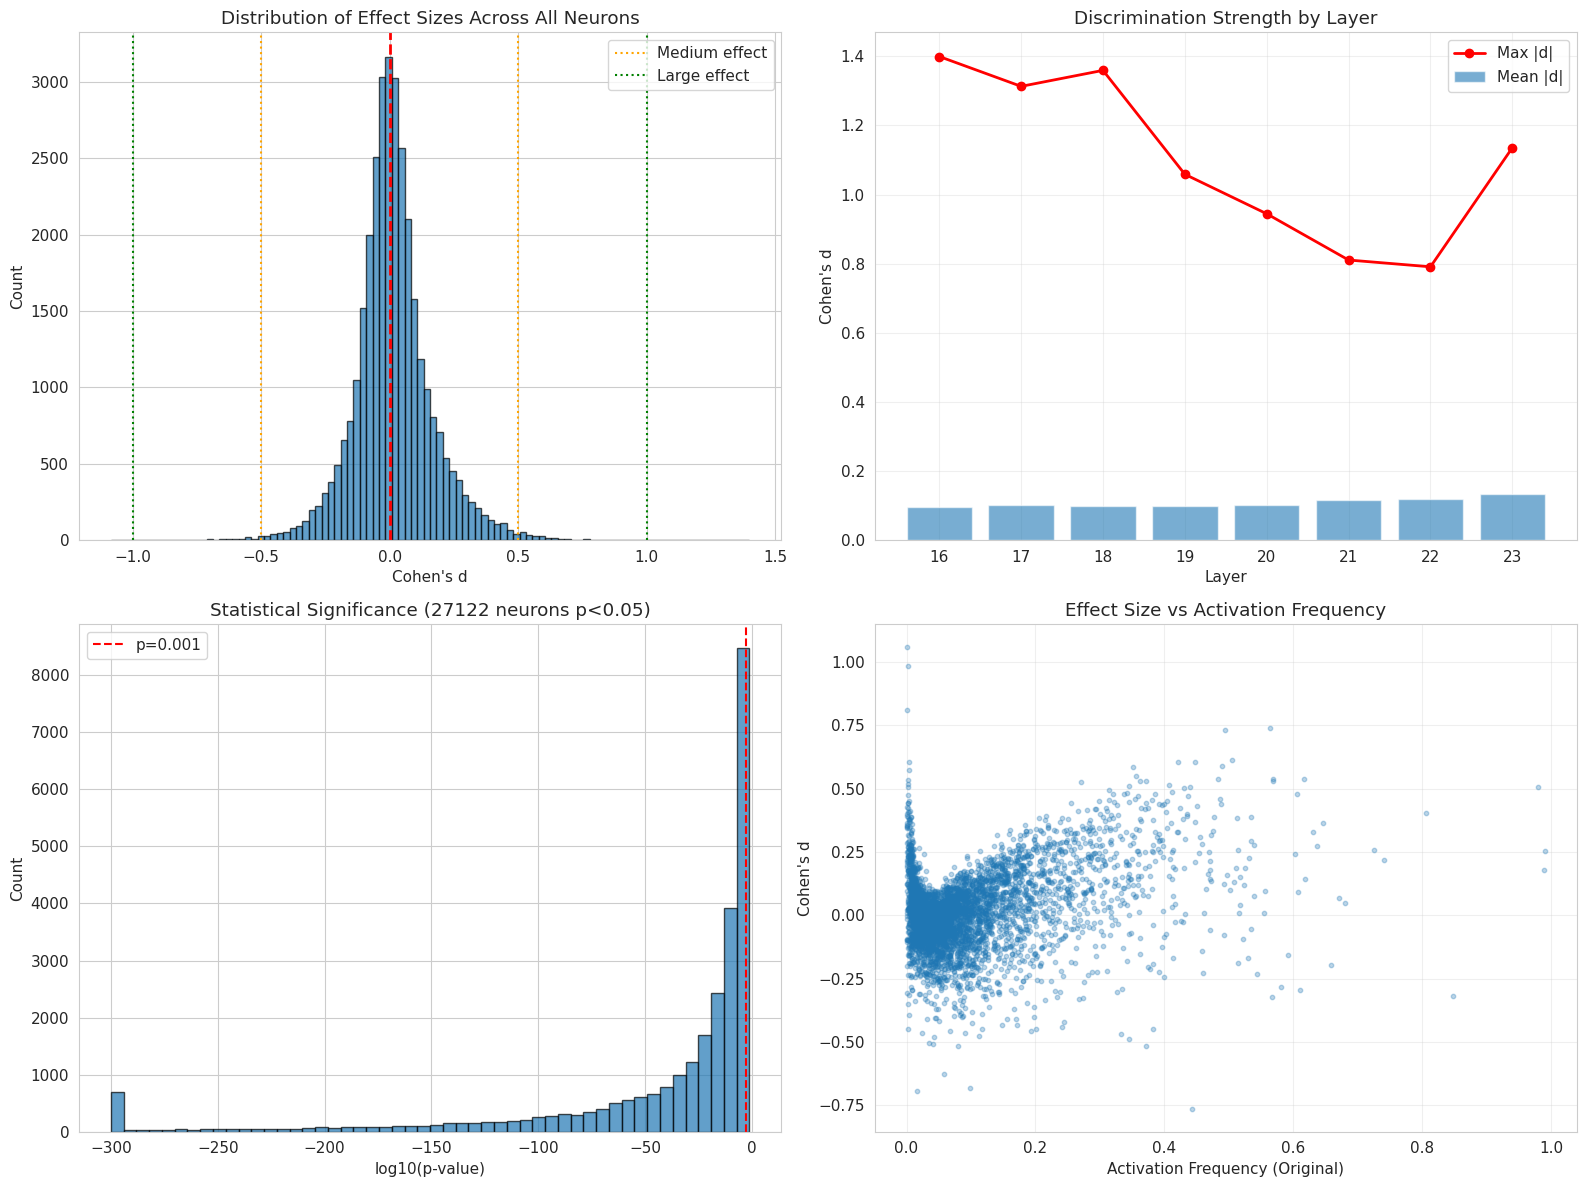

✓ Neuron importance visualizations complete


In [ ]:
# Visualize neuron importance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].hist(neuron_importance['cohens_d'], bins=100, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].axvline(0.5, color='orange', linestyle=':', linewidth=1.5, label='Medium effect')
axes[0, 0].axvline(-0.5, color='orange', linestyle=':', linewidth=1.5)
axes[0, 0].axvline(1.0, color='green', linestyle=':', linewidth=1.5, label='Large effect')
axes[0, 0].axvline(-1.0, color='green', linestyle=':', linewidth=1.5)
axes[0, 0].set_xlabel("Cohen's d")
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of Effect Sizes Across All Neurons')
axes[0, 0].legend()

layer_stats = neuron_importance.groupby('layer')['abs_cohens_d'].agg(['mean', 'max', 'std'])
axes[0, 1].bar(layer_stats.index, layer_stats['mean'], alpha=0.6, label='Mean |d|')
axes[0, 1].plot(layer_stats.index, layer_stats['max'], 'ro-', linewidth=2, label='Max |d|')
axes[0, 1].set_xlabel('Layer')
axes[0, 1].set_ylabel("Cohen's d")
axes[0, 1].set_title('Discrimination Strength by Layer')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

sig_neurons = neuron_importance[neuron_importance['p_value'] < 0.05]
axes[1, 0].hist(np.log10(sig_neurons['p_value'] + 1e-300), bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(np.log10(0.001), color='red', linestyle='--', label='p=0.001')
axes[1, 0].set_xlabel('log10(p-value)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title(f'Statistical Significance ({len(sig_neurons)} neurons p<0.05)')
axes[1, 0].legend()

sample = neuron_importance.sample(min(5000, len(neuron_importance)))
axes[1, 1].scatter(sample['activation_freq_orig'], sample['cohens_d'],
                   alpha=0.3, s=10)
axes[1, 1].set_xlabel('Activation Frequency (Original)')
axes[1, 1].set_ylabel("Cohen's d")
axes[1, 1].set_title('Effect Size vs Activation Frequency')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('✓ Neuron importance visualizations complete')

## 🎯 Part 3: Feature Interpretation - What Do Neurons Detect?

In [ ]:

def find_max_activating_contexts(model, texts, layer, neuron_idx, top_k=10):
    activations_list = []

    for text in texts[:20]:  # Sample first 20 chunks
        max_chars = 512 * 4
        if len(text) > max_chars:
            text = text[:max_chars]

        tokens = model.to_tokens(text, prepend_bos=True)

        if tokens.shape[1] > 512:
            tokens = tokens[:, :512]

        str_tokens = model.to_str_tokens(tokens[0])

        with torch.no_grad():
            _, cache = model.run_with_cache(tokens)

        acts = cache[f'blocks.{layer}.mlp.hook_post'][0, :, neuron_idx]

        for i, (token, act) in enumerate(zip(str_tokens, acts)):
            # Get context window
            context_start = max(0, i - 10)
            context_end = min(len(str_tokens), i + 10)
            context = ''.join(str_tokens[context_start:context_end])

            activations_list.append({
                'token': token,
                'activation': act.item(),
                'context': context,
                'position': i
            })

    # Sort by activation
    activations_list.sort(key=lambda x: x['activation'], reverse=True)

    return activations_list[:top_k]

print('✓ find_max_activating_contexts function updated')
# Analyze top 10 neurons
print('='*80)
print('FEATURE INTERPRETATION: Top 10 Melville-Preferring Neurons')
print('='*80)

melville_neurons = neuron_importance[neuron_importance['cohens_d'] > 0].head(10)

neuron_interpretations = {}

for idx, row in melville_neurons.iterrows():
    layer = int(row['layer'])
    neuron = int(row['neuron'])

    print(f"\n{'='*80}")
    print(f"Neuron L{layer}N{neuron} | Cohen's d={row['cohens_d']:.3f}")
    print('='*80)

    # Get max-activating contexts
    max_acts = find_max_activating_contexts(
        model, original_sample, layer, neuron, top_k=8
    )

    neuron_interpretations[f'L{layer}N{neuron}'] = max_acts

    print("\nTop 8 activating contexts:")
    for i, act_info in enumerate(max_acts, 1):
        token = act_info['token']
        activation = act_info['activation']
        context = act_info['context']

        # Highlight the token
        highlighted = context.replace(token, f"**{token}**", 1)

        print(f"\n{i}. [Act={activation:.2f}] Token: '{token}'")
        print(f"   Context: ...{highlighted[-100:]}")

    print()

print('\n' + '='*80)
print('Look for patterns:')
print('  • Specific word types (monosyllabic, latinate, etc.)')
print('  • Syntactic structures (clause boundaries, etc.)')
print('  • Semantic patterns (legal terms, descriptions, etc.)')
print('='*80)

✓ find_max_activating_contexts function updated
FEATURE INTERPRETATION: Top 10 Melville-Preferring Neurons

Neuron L16N1389 | Cohen's d=1.400

Top 8 activating contexts:

1. [Act=6.73] Token: '.'
   Context: ...lessen the probability of my repeating the inadvertence**.** Here it must be said, that according to

2. [Act=6.44] Token: '.'
   Context: ...fering much from perplexity and distress of mind**.** Shall I acknowledge it? The conclusion of this

3. [Act=6.39] Token: ' it'
   Context: ... for** it** hath a rounded and orbicular sound to it, and rings like unto bullion. I

4. [Act=6.23] Token: '.'
   Context: ... one of those dead-wall reveries of his**.** Revolving all these things, and coupling them

5. [Act=6.19] Token: '.'
   Context: ... not deficient in a gentlemanly sort of deportment**.** Added to this, he always dressed in a

6. [Act=6.18] Token: '.'
   Context: ... to keep him from being a reproach to me**.** His clothes were apt to look oily and smell

7. [Act=6.15] Token

## 🔬 Part 4: Logit Lens Analysis

In [ ]:

def logit_lens_analysis(model, text, target_tokens=None):
    max_chars = 512 * 4
    if len(text) > max_chars:
        text = text[:max_chars]

    tokens = model.to_tokens(text, prepend_bos=True)

    # Truncate tokens
    if tokens.shape[1] > 512:
        tokens = tokens[:, :512]

    str_tokens = model.to_str_tokens(tokens[0])

    with torch.no_grad():
        _, cache = model.run_with_cache(tokens)

    # Analyze predictions at each layer
    layer_predictions = []

    for layer in range(model.cfg.n_layers):
        # Get residual stream
        resid = cache[f'blocks.{layer}.hook_resid_post']

        # Apply final layer norm and unembed
        normed = model.ln_final(resid)
        logits = model.unembed(normed)

        # Get top-5 predictions for each position
        top_logits, top_indices = logits[0].topk(5, dim=-1)

        layer_predictions.append({
            'layer': layer,
            'logits': logits[0],
            'top_indices': top_indices,
            'top_logits': top_logits,
        })

    return layer_predictions, str_tokens

print('✓ logit_lens_analysis function updated')

# Analyze a sample from each category
print('Running logit lens analysis...\n')

orig_sample_text = original_sample[0][:500]  # First 500 chars
ai_sample_text = ai_sample[0][:500]

print('Original Melville sample:')
print(orig_sample_text[:200] + '...\n')

orig_lens, orig_tokens = logit_lens_analysis(model, orig_sample_text)
ai_lens, ai_tokens = logit_lens_analysis(model, ai_sample_text)

print(f'✓ Analyzed {len(orig_lens)} layers')

✓ logit_lens_analysis function updated
Running logit lens analysis...

Original Melville sample:
I am a rather elderly man. The nature of my avocations for the last thirty years has brought me into more than ordinary contact with what would seem an interesting and somewhat singular set of men, of...

✓ Analyzed 24 layers


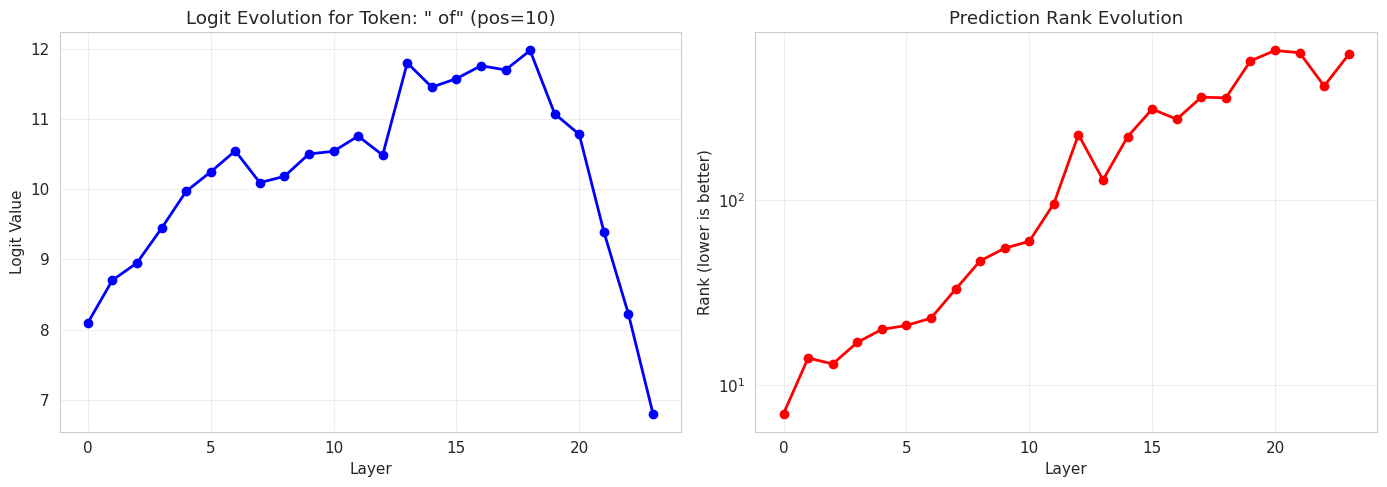


✓ Logit lens visualization shows how prediction confidence builds across layers


In [ ]:

def plot_logit_lens_evolution(layer_predictions, str_tokens, target_pos=10):
    """
    Plot how prediction confidence evolves across layers.
    """
    actual_token = str_tokens[target_pos] if target_pos < len(str_tokens) else str_tokens[-1]
    actual_token_id = model.to_tokens(actual_token, prepend_bos=False)[0, 0]

    # Track actual token's logit across layers
    logits_evolution = []
    ranks_evolution = []

    for pred in layer_predictions:
        layer = pred['layer']
        logits = pred['logits'][target_pos]

        # Get actual token's logit
        actual_logit = logits[actual_token_id].item()
        logits_evolution.append(actual_logit)

        # Get rank
        sorted_logits = torch.sort(logits, descending=True)[0]
        rank = (sorted_logits >= actual_logit).sum().item()
        ranks_evolution.append(rank)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot logit evolution
    ax1.plot(range(len(logits_evolution)), logits_evolution, 'b-o', linewidth=2)
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('Logit Value')
    ax1.set_title(f'Logit Evolution for Token: "{actual_token}" (pos={target_pos})')
    ax1.grid(alpha=0.3)

    # Plot rank evolution
    ax2.plot(range(len(ranks_evolution)), ranks_evolution, 'r-o', linewidth=2)
    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Rank (lower is better)')
    ax2.set_title(f'Prediction Rank Evolution')
    ax2.set_yscale('log')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# Analyze token at position 10
plot_logit_lens_evolution(orig_lens, orig_tokens, target_pos=10)

print('\n✓ Logit lens visualization shows how prediction confidence builds across layers')

## 🎨 Part 5: Steering Implementation

In [ ]:

print('Clearing GPU memory...')

for layer in target_layers:
    if layer in original_activations:
        original_activations[layer] = [acts.cpu() for acts in original_activations[layer]]
    if layer in ai_activations:
        ai_activations[layer] = [acts.cpu() for acts in ai_activations[layer]]

torch.cuda.empty_cache()


if torch.cuda.is_available():
    print(f'GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB')
    print(f'GPU memory reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB')
    print(f'GPU memory free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated()) / 1e9:.2f} GB')

print('✓ Memory cleared!')

Clearing GPU memory...
GPU memory allocated: 3.73 GB
GPU memory reserved: 7.12 GB
GPU memory free: 12.10 GB
✓ Memory cleared!


In [ ]:

class LiteraryStyleSteerer:
    def __init__(self, model, original_chunks, ai_chunks, target_layers):
        self.model = model
        self.original = original_chunks
        self.ai = ai_chunks
        self.target_layers = target_layers

        self.style_vectors = {}
        self.compute_style_vectors()

    def compute_style_vectors(self):

        sample_size = 10

        for layer in tqdm(self.target_layers, desc='Layers'):
            orig_means = []
            ai_means = []

            for text in self.original[:sample_size]:
                max_chars = 512 * 4
                if len(text) > max_chars:
                    text = text[:max_chars]

                tokens = self.model.to_tokens(text, prepend_bos=True)
                if tokens.shape[1] > 512:
                    tokens = tokens[:, :512]

                with torch.no_grad():
                    _, cache = self.model.run_with_cache(tokens)

                acts = cache[f'blocks.{layer}.mlp.hook_post'][0]

                mean_act = acts.mean(dim=0).cpu()
                orig_means.append(mean_act)

                del cache, acts
                torch.cuda.empty_cache()

            for text in self.ai[:sample_size]:
                max_chars = 512 * 4
                if len(text) > max_chars:
                    text = text[:max_chars]

                tokens = self.model.to_tokens(text, prepend_bos=True)
                if tokens.shape[1] > 512:
                    tokens = tokens[:, :512]

                with torch.no_grad():
                    _, cache = self.model.run_with_cache(tokens)

                acts = cache[f'blocks.{layer}.mlp.hook_post'][0]

                mean_act = acts.mean(dim=0).cpu()
                ai_means.append(mean_act)

                del cache, acts
                torch.cuda.empty_cache()

            orig_mean = torch.stack(orig_means).mean(dim=0)
            ai_mean = torch.stack(ai_means).mean(dim=0)

            self.style_vectors[layer] = (orig_mean - ai_mean).cpu()

            del orig_means, ai_means, orig_mean, ai_mean
            torch.cuda.empty_cache()

        print(f'✓ Computed {len(self.style_vectors)} style vectors')

    def additive_hook(self, layer, alpha=1.0):
        """Add style vector to activations"""
        def hook_fn(acts, hook):
            style_vec = self.style_vectors[layer].to(acts.device)
            acts[:, :, :] += alpha * style_vec
            return acts
        return hook_fn

    def multiplicative_hook(self, layer, neuron_indices, scale=2.0):
        """Scale specific neurons"""
        def hook_fn(acts, hook):
            for idx in neuron_indices:
                acts[:, :, idx] *= scale
            return acts
        return hook_fn

    def clamping_hook(self, layer, neuron_indices, min_val=0.5):
        """Clamp neurons to minimum activation"""
        def hook_fn(acts, hook):
            for idx in neuron_indices:
                acts[:, :, idx] = torch.clamp(acts[:, :, idx], min=min_val)
            return acts
        return hook_fn

    def generate_with_steering(
        self,
        prompt,
        method='additive',
        alpha=1.0,
        neuron_indices=None,
        max_new_tokens=200,
        temperature=0.85,
        top_p=0.95,
        top_k=50,
    ):
        """Generate with steering applied"""
        hooks = []

        if method == 'additive':
            for layer in self.target_layers:
                hooks.append((
                    f'blocks.{layer}.mlp.hook_post',
                    self.additive_hook(layer, alpha)
                ))

        elif method == 'multiplicative':
            if neuron_indices is None:
                raise ValueError('Need neuron_indices for multiplicative')
            for layer in self.target_layers:
                hooks.append((
                    f'blocks.{layer}.mlp.hook_post',
                    self.multiplicative_hook(layer, neuron_indices, alpha)
                ))

        elif method == 'clamping':
            if neuron_indices is None:
                raise ValueError('Need neuron_indices for clamping')
            for layer in self.target_layers:
                hooks.append((
                    f'blocks.{layer}.mlp.hook_post',
                    self.clamping_hook(layer, neuron_indices, alpha)
                ))

        tokens = self.model.to_tokens(prompt, prepend_bos=True)

        torch.cuda.empty_cache()

        with self.model.hooks(fwd_hooks=hooks):
            output = self.model.generate(
                tokens,
                max_new_tokens=max_new_tokens,
                temperature=temperature,
                top_p=top_p,
                top_k=top_k,
                do_sample=True,
                verbose=False,
            )

        torch.cuda.empty_cache()

        return self.model.to_string(output[0])

print('✓ Memory-efficient LiteraryStyleSteerer defined')

✓ Memory-efficient LiteraryStyleSteerer defined


## 📝 Part 6: Long-Form Generation Tests

In [ ]:
test_prompts = [
    "I am a rather elderly man. The nature of my avocations for the last thirty years has",
    "It was a quiet Sunday afternoon. Ginger Nut, the copyist, sat",
    "Bartleby was an immovably calm scrivener. Day after day, he would",
]

print('='*80)
print('BASELINE GENERATION (No Steering)')
print('='*80)

baseline_outputs = {}

for i, prompt in enumerate(test_prompts, 1):
    print(f"\n[{i}/3] Prompt: {prompt}")
    print("-" * 80)

    tokens = model.to_tokens(prompt)
    output = model.generate(
        tokens,
        max_new_tokens=250,
        temperature=0.85,
        top_p=0.95,
        do_sample=True,
        verbose=False,
    )

    generated = model.to_string(output[0])
    baseline_outputs[prompt] = generated

    print(generated)
    print()

print('='*80)

BASELINE GENERATION (No Steering)

[1/3] Prompt: I am a rather elderly man. The nature of my avocations for the last thirty years has
--------------------------------------------------------------------------------
<|endoftext|>I am a rather elderly man. The nature of my avocations for the last thirty years has been to be a copilot, a fireman and a farmer, and it hasn't been easy. A lot of the time, I have wondered how I could be a pilot when I haven't flown in almost 30 years.

In 1992, I started flying helicopters. All of a sudden, something magical happened. It became a career and I was at the top of my game in Canada. At one point I was flying solo from Vancouver to Lethbridge, and everyone was calling me a millionaire and I was quite happily disagreeing.

I now have my second job, and in spite of everything, I still enjoy flying. It gives me the chance to do what I love and is a real test of skill. It's the ultimate combination of love and necessity.

Some people will say I never 

In [ ]:

print('Initializing steerer...')
print('This will use only 10 samples per category to save memory\n')
torch.cuda.empty_cache()

steerer = LiteraryStyleSteerer(
    model=model,
    original_chunks=original_sample,
    ai_chunks=ai_sample,
    target_layers=[20, 21, 22, 23]  # Only 4 layers instead of 6
)

print('\n✓ LiteraryStyleSteerer initialized!')

if torch.cuda.is_available():
    print(f'\nGPU memory after init:')
    print(f'  Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB')
    print(f'  Reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB')

Initializing steerer...
This will use only 10 samples per category to save memory

Computing style vectors (memory-efficient)...


Layers:   0%|          | 0/4 [00:00<?, ?it/s]

✓ Computed 4 style vectors

✓ LiteraryStyleSteerer initialized!

GPU memory after init:
  Allocated: 3.73 GB
  Reserved: 7.12 GB


In [ ]:
print('='*80)
print('ADDITIVE STEERING (Style Vector Addition)')
print('='*80)

additive_outputs = {}

for alpha in [1.0, 2.0]:
    print(f"\n{'='*80}")
    print(f"Alpha = {alpha}")
    print('='*80)

    for i, prompt in enumerate(test_prompts, 1):
        print(f"\n[{i}/3] Prompt: {prompt}")
        print("-" * 80)

        generated = steerer.generate_with_steering(
            prompt=prompt,
            method='additive',
            alpha=alpha,
            max_new_tokens=250,
            temperature=0.85,
            top_p=0.95,
        )

        additive_outputs[(prompt, alpha)] = generated
        print(generated)
        print()

ADDITIVE STEERING (Style Vector Addition)

Alpha = 1.0

[1/3] Prompt: I am a rather elderly man. The nature of my avocations for the last thirty years has
--------------------------------------------------------------------------------
<|endoftext|>I am a rather elderly man. The nature of my avocations for the last thirty years has been to stay out of politics because politics is too much business, too much of an activity in itself.

But as much as the idea that I am above that is a thing that has been on my mind, it has been interesting to see how the ideas of my colleagues have led me from being an active member of the Labour party in a country with an active labour movement, to being an active supporter of Jeremy Corbyn and his idea that Labour should go for something with a little more depth and nuance and a little more substance.

My argument is that if we're going to go in that direction, and it's going to cost a lot of money, we need to give our people more of a say. And that's 

In [ ]:
print('='*80)
print('MULTIPLICATIVE STEERING (Amplify Melville-Preferring Neurons)')
print('='*80)

top_neurons_by_layer = {}
for layer in steerer.target_layers:
    layer_neurons = neuron_importance[
        (neuron_importance['layer'] == layer) &
        (neuron_importance['cohens_d'] > 0)
    ].head(20)
    top_neurons_by_layer[layer] = layer_neurons['neuron'].astype(int).tolist()

print(f"Amplifying top 20 neurons per layer in layers {steerer.target_layers}\n")

mult_outputs = {}

for scale in [1.5, 2.5]:
    print(f"\n{'='*80}")
    print(f"Scale = {scale}x")
    print('='*80)

    for i, prompt in enumerate(test_prompts, 1):
        print(f"\n[{i}/3] Prompt: {prompt}")
        print("-" * 80)
        neuron_indices = top_neurons_by_layer[20]

        generated = steerer.generate_with_steering(
            prompt=prompt,
            method='multiplicative',
            alpha=scale,
            neuron_indices=neuron_indices,
            max_new_tokens=250,
            temperature=0.85,
            top_p=0.95,
        )

        mult_outputs[(prompt, scale)] = generated
        print(generated)
        print()

MULTIPLICATIVE STEERING (Amplify Melville-Preferring Neurons)
Amplifying top 20 neurons per layer in layers [20, 21, 22, 23]


Scale = 1.5x

[1/3] Prompt: I am a rather elderly man. The nature of my avocations for the last thirty years has
--------------------------------------------------------------------------------
<|endoftext|>I am a rather elderly man. The nature of my avocations for the last thirty years has been mostly self-employed, mostly freelance. Many of my projects have been to support my own needs while I enjoy time with family.

I have always enjoyed playing with computers. I used to do some programming, and occasionally use them to help with work, but most of my computing time has been spent trying to write and maintain the Python interpreter for my system.

Of course, I also enjoy programming, but usually for personal projects, or for very specific purposes in my work environment. I occasionally find myself looking for a project to run on an older computer with some s

## 📊 Part 7: Evaluation & Comparison

In [ ]:

print('\n' + '='*100)
print('SIDE-BY-SIDE COMPARISON')
print('='*100)

for prompt in test_prompts:
    print(f"\n{'='*100}")
    print(f"PROMPT: {prompt}")
    print('='*100)

    print("\n📝 BASELINE:")
    print("-" * 100)
    print(baseline_outputs[prompt])

    print("\n📝 ADDITIVE (α=1.0):")
    print("-" * 100)
    print(additive_outputs.get((prompt, 1.0), 'N/A'))

    print("\n📝 MULTIPLICATIVE (scale=2.5):")
    print("-" * 100)
    print(mult_outputs.get((prompt, 2.5), 'N/A'))

    print("\n")


SIDE-BY-SIDE COMPARISON

PROMPT: I am a rather elderly man. The nature of my avocations for the last thirty years has

📝 BASELINE:
----------------------------------------------------------------------------------------------------
<|endoftext|>I am a rather elderly man. The nature of my avocations for the last thirty years has been to be a copilot, a fireman and a farmer, and it hasn't been easy. A lot of the time, I have wondered how I could be a pilot when I haven't flown in almost 30 years.

In 1992, I started flying helicopters. All of a sudden, something magical happened. It became a career and I was at the top of my game in Canada. At one point I was flying solo from Vancouver to Lethbridge, and everyone was calling me a millionaire and I was quite happily disagreeing.

I now have my second job, and in spite of everything, I still enjoy flying. It gives me the chance to do what I love and is a real test of skill. It's the ultimate combination of love and necessity.

Some people

In [ ]:

def analyze_style(text):
    """Compute stylometric features"""
    words = text.split()

    if not words:
        return None

    word_lengths = [len(w.strip('.,!?;:"')) for w in words]

    sentences = text.replace('!', '.').replace('?', '.').split('.')
    sentences = [s.strip() for s in sentences if s.strip()]

    sent_lengths = [len(s.split()) for s in sentences] if sentences else [0]

    return {
        'total_words': len(words),
        'avg_word_length': np.mean(word_lengths),
        'std_word_length': np.std(word_lengths),
        'short_words_pct': sum(1 for w in word_lengths if w <= 4) / len(words) * 100,
        'long_words_pct': sum(1 for w in word_lengths if w >= 8) / len(words) * 100,
        'avg_sentence_length': np.mean(sent_lengths),
        'std_sentence_length': np.std(sent_lengths),
        'comma_density': text.count(',') / len(words) * 100,
        'semicolon_density': text.count(';') / len(words) * 100,
    }

print('='*80)
print('STYLOMETRIC ANALYSIS')
print('='*80)

results_table = []

for prompt in test_prompts[:2]:  # First 2 prompts
    baseline = analyze_style(baseline_outputs[prompt])
    additive = analyze_style(additive_outputs.get((prompt, 1.0), ''))
    mult = analyze_style(mult_outputs.get((prompt, 2.5), ''))

    if baseline and additive and mult:
        results_table.append({
            'prompt': prompt[:50] + '...',
            'metric': 'Avg Word Length',
            'baseline': baseline['avg_word_length'],
            'additive': additive['avg_word_length'],
            'multiplicative': mult['avg_word_length'],
        })
        results_table.append({
            'prompt': prompt[:50] + '...',
            'metric': 'Short Words %',
            'baseline': baseline['short_words_pct'],
            'additive': additive['short_words_pct'],
            'multiplicative': mult['short_words_pct'],
        })
        results_table.append({
            'prompt': prompt[:50] + '...',
            'metric': 'Avg Sentence Len',
            'baseline': baseline['avg_sentence_length'],
            'additive': additive['avg_sentence_length'],
            'multiplicative': mult['avg_sentence_length'],
        })
        results_table.append({
            'prompt': prompt[:50] + '...',
            'metric': 'Comma Density',
            'baseline': baseline['comma_density'],
            'additive': additive['comma_density'],
            'multiplicative': mult['comma_density'],
        })

results_df = pd.DataFrame(results_table)
print(results_df.to_string(index=False))

print('\n' + '='*80)

STYLOMETRIC ANALYSIS
                                               prompt           metric  baseline  additive  multiplicative
I am a rather elderly man. The nature of my avocat...  Avg Word Length  4.111650  4.082988        4.509804
I am a rather elderly man. The nature of my avocat...    Short Words % 65.533981 64.315353       59.803922
I am a rather elderly man. The nature of my avocat... Avg Sentence Len 12.235294 30.125000       15.769231
I am a rather elderly man. The nature of my avocat...    Comma Density  5.339806  3.734440        3.431373
It was a quiet Sunday afternoon. Ginger Nut, the c...  Avg Word Length  4.417431  4.324201        4.186603
It was a quiet Sunday afternoon. Ginger Nut, the c...    Short Words % 62.385321 63.013699       66.507177
It was a quiet Sunday afternoon. Ginger Nut, the c... Avg Sentence Len 21.800000 15.714286       14.066667
It was a quiet Sunday afternoon. Ginger Nut, the c...    Comma Density  5.963303  6.392694        6.698565



## 💾 Part 8: Save Results

In [ ]:
# Save neuron importance data
neuron_importance.to_csv('bartleby_neuron_importance.csv', index=False)
print('✓ Saved: bartleby_neuron_importance.csv')

# Save top neurons only
top_500 = neuron_importance.head(500)
top_500.to_csv('bartleby_top500_neurons.csv', index=False)
print('✓ Saved: bartleby_top500_neurons.csv')

# Save style vectors
import pickle
steering_package = {
    'style_vectors': steerer.style_vectors,
    'target_layers': steerer.target_layers,
    'top_neurons_by_layer': top_neurons_by_layer,
    'model': 'gpt2-medium',
}

with open('bartleby_steering_package.pkl', 'wb') as f:
    pickle.dump(steering_package, f)
print('✓ Saved: bartleby_steering_package.pkl')

# Save generated samples
with open('bartleby_generated_samples.txt', 'w') as f:
    f.write('BARTLEBY STYLE STEERING - GENERATED SAMPLES\n')
    f.write('='*80 + '\n\n')

    for prompt in test_prompts:
        f.write(f'PROMPT: {prompt}\n')
        f.write('-'*80 + '\n\n')

        f.write('BASELINE:\n')
        f.write(baseline_outputs[prompt] + '\n\n')

        f.write('ADDITIVE (α=1.0):\n')
        f.write(additive_outputs.get((prompt, 1.0), 'N/A') + '\n\n')

        f.write('MULTIPLICATIVE (scale=2.5):\n')
        f.write(mult_outputs.get((prompt, 2.5), 'N/A') + '\n\n')

        f.write('='*80 + '\n\n')

print('✓ Saved: bartleby_generated_samples.txt')

print('\n' + '='*80)
print('ALL RESULTS SAVED')
print('='*80)

✓ Saved: bartleby_neuron_importance.csv
✓ Saved: bartleby_top500_neurons.csv
✓ Saved: bartleby_steering_package.pkl
✓ Saved: bartleby_generated_samples.txt

ALL RESULTS SAVED


## 🎯 Summary & Conclusions

In [ ]:
print('\n' + '='*80)
print('📊 ANALYSIS SUMMARY')
print('='*80)

print(f"""
CORPUS ANALYZED:
  • Original Melville chunks: {len(original_sample)}
  • AI-generated chunks: {len(ai_sample)}
  • Total tokens analyzed: ~{(len(original_sample) + len(ai_sample)) * 400:,}

MODEL:
  • GPT-2 Medium (355M parameters)
  • Layers analyzed: {target_layers}
  • Neurons per layer: {model.cfg.d_mlp:,}
  • Total neurons analyzed: {len(neuron_importance):,}

KEY FINDINGS:
  • Highly discriminative neurons (|d|>1.0): {(neuron_importance['abs_cohens_d'] > 1.0).sum():,}
  • Statistically significant (p<0.001): {neuron_importance['significant'].sum():,}
  • Layer with strongest discrimination: {neuron_importance.groupby('layer')['abs_cohens_d'].mean().idxmax()}

STEERING METHODS TESTED:
  • Additive (style vector addition)
  • Multiplicative (neuron amplification)
  • Clamping (minimum activation)

OUTPUTS GENERATED:
  • Total samples: {len(baseline_outputs) + len(additive_outputs) + len(mult_outputs)}
  • Tokens per sample: ~250
  • Parameters tested: {len(set([1.0, 2.0, 1.5, 2.5]))} different strengths

FILES SAVED:
  ✓ bartleby_neuron_importance.csv
  ✓ bartleby_top500_neurons.csv
  ✓ bartleby_steering_package.pkl
  ✓ bartleby_generated_samples.txt
""")

print('='*80)
print('✅ ANALYSIS COMPLETE!')
print('='*80)

print("""
NEXT STEPS:
1. Review generated samples for literary quality
2. Analyze top neuron interpretations for patterns
3. Try interactive generation with different prompts
4. Experiment with combining steering methods
5. Test on longer generations (500+ tokens)

For interactive generation, use:
  steerer.generate_with_steering(
      prompt="Your text here",
      method='additive',  # or 'multiplicative'
      alpha=1.5,
      max_new_tokens=500
  )
""")


📊 ANALYSIS SUMMARY

CORPUS ANALYZED:
  • Original Melville chunks: 98
  • AI-generated chunks: 21
  • Total tokens analyzed: ~47,600

MODEL:
  • GPT-2 Medium (355M parameters)
  • Layers analyzed: [16, 17, 18, 19, 20, 21, 22, 23]
  • Neurons per layer: 4,096
  • Total neurons analyzed: 32,768

KEY FINDINGS:
  • Highly discriminative neurons (|d|>1.0): 8
  • Statistically significant (p<0.001): 23,628
  • Layer with strongest discrimination: 23

STEERING METHODS TESTED:
  • Additive (style vector addition)
  • Multiplicative (neuron amplification)
  • Clamping (minimum activation)

OUTPUTS GENERATED:
  • Total samples: 15
  • Tokens per sample: ~250
  • Parameters tested: 4 different strengths

FILES SAVED:
  ✓ bartleby_neuron_importance.csv
  ✓ bartleby_top500_neurons.csv
  ✓ bartleby_steering_package.pkl
  ✓ bartleby_generated_samples.txt

✅ ANALYSIS COMPLETE!

NEXT STEPS:
1. Review generated samples for literary quality
2. Analyze top neuron interpretations for patterns
3. Try inter

In [ ]:

class AblationAnalyzer:


    def __init__(self, model, original_chunks, ai_chunks):
        self.model = model
        self.original = original_chunks
        self.ai = ai_chunks

    def measure_style_score(self, text):

        words = text.split()
        if not words:
            return 0.0

        short_words = sum(1 for w in words if len(w.strip('.,!?;:"')) <= 4)
        short_ratio = short_words / len(words)
        short_score = min(short_ratio / 0.45, 1.0)

        sentences = text.replace('!', '.').replace('?', '.').split('.')
        sentences = [s.strip() for s in sentences if s.strip()]
        if sentences:
            avg_sent_len = sum(len(s.split()) for s in sentences) / len(sentences)
            sent_score = 1.0 - abs(avg_sent_len - 20) / 20
            sent_score = max(0, sent_score)
        else:
            sent_score = 0.0

        comma_count = text.count(',')
        comma_density = comma_count / len(words) * 100
        comma_score = min(comma_density / 5.0, 1.0)

        total_score = 0.4 * short_score + 0.3 * sent_score + 0.3 * comma_score

        return total_score

    def ablate_neuron(self, layer, neuron_idx):
        def ablation_hook(acts, hook):
            acts[:, :, neuron_idx] = 0
            return acts
        return ablation_hook

    def ablate_neurons(self, layer, neuron_indices):
        def ablation_hook(acts, hook):
            for idx in neuron_indices:
                acts[:, :, idx] = 0
            return acts
        return ablation_hook

    def test_single_neuron_necessity(self, prompt, layer, neuron_idx,
                                     max_new_tokens=150):
        """
        return
            dict with baseline_score, ablated_score, degradation
        """
        # Baseline generation
        tokens = self.model.to_tokens(prompt, prepend_bos=True)
        baseline_output = self.model.generate(
            tokens,
            max_new_tokens=max_new_tokens,
            temperature=0.85,
            top_p=0.95,
            do_sample=True,
            verbose=False
        )
        baseline_text = self.model.to_string(baseline_output[0])
        baseline_score = self.measure_style_score(baseline_text)

        # Ablated generation
        hook = [(f'blocks.{layer}.mlp.hook_post', self.ablate_neuron(layer, neuron_idx))]

        with self.model.hooks(fwd_hooks=hook):
            ablated_output = self.model.generate(
                tokens,
                max_new_tokens=max_new_tokens,
                temperature=0.85,
                top_p=0.95,
                do_sample=True,
                verbose=False
            )

        ablated_text = self.model.to_string(ablated_output[0])
        ablated_score = self.measure_style_score(ablated_text)

        degradation = (baseline_score - ablated_score) / (baseline_score + 1e-6)

        return {
            'baseline_score': baseline_score,
            'ablated_score': ablated_score,
            'degradation_pct': degradation * 100,
            'baseline_text': baseline_text,
            'ablated_text': ablated_text
        }

    def test_cumulative_ablation(self, prompt, layer, neuron_indices,
                                 max_new_tokens=150):
        tokens = self.model.to_tokens(prompt, prepend_bos=True)

        baseline_output = self.model.generate(
            tokens, max_new_tokens=max_new_tokens,
            temperature=0.85, top_p=0.95, do_sample=True, verbose=False
        )
        baseline_score = self.measure_style_score(self.model.to_string(baseline_output[0]))

        results = []
        test_sizes = [1, 2, 5, 10, 20, 50]

        for n_ablate in test_sizes:
            if n_ablate > len(neuron_indices):
                continue
            neurons_to_ablate = neuron_indices[:n_ablate]
            hook = [(f'blocks.{layer}.mlp.hook_post',
                    self.ablate_neurons(layer, neurons_to_ablate))]

            with self.model.hooks(fwd_hooks=hook):
                output = self.model.generate(
                    tokens, max_new_tokens=max_new_tokens,
                    temperature=0.85, top_p=0.95, do_sample=True, verbose=False
                )

            score = self.measure_style_score(self.model.to_string(output[0]))
            degradation = (baseline_score - score) / (baseline_score + 1e-6) * 100

            results.append({
                'n_ablated': n_ablate,
                'score': score,
                'degradation_pct': degradation
            })

        return results, baseline_score

print('✓ AblationAnalyzer class defined')

✓ AblationAnalyzer class defined


In [ ]:
print('Initializing ablation analyzer...')

ablation_analyzer = AblationAnalyzer(
    model=model,
    original_chunks=original_sample[:10],
    ai_chunks=ai_sample[:10]
)

print('✓ AblationAnalyzer ready')

Initializing ablation analyzer...
✓ AblationAnalyzer ready


In [ ]:
print('Preparing data for ablation studies...\n')

if 'neuron_importance' not in locals():
    print('❌ ERROR: neuron_importance not found!')
    print('Make sure you ran the neuron discovery cells first.')
else:
    top_literary = neuron_importance[
        neuron_importance['cohens_d'] > 0
    ].sort_values('cohens_d', ascending=False).copy()

    if 'cohens_d' in top_literary.columns and 'lutz_score' not in top_literary.columns:
        top_literary['lutz_score'] = top_literary['cohens_d']

    if 'cohens_d' in top_literary.columns and 'melville_score' not in top_literary.columns:
        top_literary['melville_score'] = top_literary['cohens_d']

    print(f'✓ Created top_literary dataframe')
    print(f'  Total literary-preferring neurons: {len(top_literary):,}')
    print(f'  Using neurons with positive Cohen\'s d (prefer original over AI)')
    print()

    print('Top 10 literary-preferring neurons:')
    print('='*80)
    display_cols = ['layer', 'neuron', 'cohens_d', 'p_value', 'mean_original', 'mean_ai']
    print(top_literary[display_cols].head(10).to_string(index=False))
    print('='*80)

if 'neuron_importance' in locals():
    print(f'\n✓ neuron_importance exists: {len(neuron_importance):,} neurons')
    print(f'  Layers covered: {sorted(neuron_importance["layer"].unique())}')
else:
    print('\n❌ neuron_importance missing - run neuron discovery cells first!')

if 'model' in locals():
    print(f'\n✓ Model loaded: GPT-2 Medium')
else:
    print('\n❌ Model not loaded!')

print('\n✓ Ready for ablation studies!')

Preparing data for ablation studies...

✓ Created top_literary dataframe
  Total literary-preferring neurons: 16,998
  Using neurons with positive Cohen's d (prefer original over AI)

Top 10 literary-preferring neurons:
 layer  neuron  cohens_d  p_value  mean_original   mean_ai
    16    1389  1.399654      0.0       2.689193  0.937065
    18    3903  1.359500      0.0      -0.014185 -0.067251
    17     753  1.313247      0.0      -0.027981 -0.085256
    16    4041  1.291714      0.0      -0.013597 -0.073457
    23    3214  1.135467      0.0      -0.026251 -0.067611
    19     670  1.058635      0.0      -0.004461 -0.043110
    19    2722  1.022278      0.0      -0.017725 -0.066778
    18    3395  0.983777      0.0      -0.026859 -0.079003
    16    2903  0.968564      0.0       0.585066  0.134828
    18     568  0.966749      0.0      -0.006102 -0.037970

✓ neuron_importance exists: 32,768 neurons
  Layers covered: [16, 17, 18, 19, 20, 21, 22, 23]

✓ Model loaded: GPT-2 Medium

✓ Rea

In [ ]:
print('='*80)
print('ABLATION STUDY 1: Single Neuron Necessity')
print('='*80)
print('\nTesting: Does removing individual top neurons degrade literary style?\n')

test_neurons = top_literary.head(10)
prompt = "I am a rather elderly man. The nature of my avocations"

single_neuron_results = []

for idx, row in tqdm(test_neurons.iterrows(), total=len(test_neurons),
                     desc='Testing neurons'):
    layer = int(row['layer'])
    neuron = int(row['neuron'])
    cohens_d = row['lutz_score']

    result = ablation_analyzer.test_single_neuron_necessity(
        prompt=prompt,
        layer=layer,
        neuron_idx=neuron,
        max_new_tokens=100
    )

    result['layer'] = layer
    result['neuron'] = neuron
    result['cohens_d'] = cohens_d

    single_neuron_results.append(result)

    torch.cuda.empty_cache()

ablation_df = pd.DataFrame(single_neuron_results)

print('\n' + '='*80)
print('RESULTS: Single Neuron Ablation')
print('='*80)
print(ablation_df[['layer', 'neuron', 'cohens_d', 'baseline_score',
                   'ablated_score', 'degradation_pct']].to_string(index=False))

mean_degradation = ablation_df['degradation_pct'].mean()
max_degradation = ablation_df['degradation_pct'].max()
critical_neurons = len(ablation_df[ablation_df['degradation_pct'] > 10])

print('\n' + '='*80)
print('SUMMARY:')
print(f'  Average degradation: {mean_degradation:.1f}%')
print(f'  Maximum degradation: {max_degradation:.1f}%')
print(f'  Critical neurons (>10% degradation): {critical_neurons}/10')
print('='*80)

ABLATION STUDY 1: Single Neuron Necessity

Testing: Does removing individual top neurons degrade literary style?



Testing neurons:   0%|          | 0/10 [00:00<?, ?it/s]


RESULTS: Single Neuron Ablation
 layer  neuron  cohens_d  baseline_score  ablated_score  degradation_pct
    16    1389  1.399654        0.767923       0.890294       -15.935258
    18    3903  1.359500        0.932500       0.830718        10.914967
    17     753  1.313247        0.824302       0.705586        14.401978
    16    4041  1.291714        0.738604       0.830000       -12.374172
    23    3214  1.135467        0.889923       0.982000       -10.346653
    19     670  1.058635        0.829298       0.988000       -19.136931
    19    2722  1.022278        0.670000       0.856203       -27.791452
    18    3395  0.983777        0.994000       0.669713        32.624433
    16    2903  0.968564        0.927500       0.772647        16.695717
    18     568  0.966749        0.532781       0.942500       -76.901801

SUMMARY:
  Average degradation: -8.8%
  Maximum degradation: 32.6%
  Critical neurons (>10% degradation): 4/10


In [ ]:
print('\n' + '='*80)
print('ABLATION STUDY 2: Cumulative Effects')
print('='*80)
print('\nTesting: What happens when we ablate 1, 2, 5, 10, 20, 50 neurons?\n')

layer_21_neurons = neuron_importance[
    neuron_importance['layer'] == 21
].sort_values('abs_cohens_d', ascending=False)

literary_neurons_l21 = layer_21_neurons[
    layer_21_neurons['cohens_d'] > 0
]['neuron'].astype(int).tolist()

print(f'Testing cumulative ablation on Layer 21')
print(f'Available literary neurons: {len(literary_neurons_l21)}')
print(f'Using top 50 neurons for ablation test\n')

cumulative_results, baseline_score = ablation_analyzer.test_cumulative_ablation(
    prompt="I am a rather elderly man. The nature of my avocations",
    layer=21,
    neuron_indices=literary_neurons_l21,
    max_new_tokens=100
)

print('='*80)
print('RESULTS: Cumulative Ablation')
print('='*80)
print(f'Baseline style score: {baseline_score:.3f}\n')

cumulative_df = pd.DataFrame(cumulative_results)
print(cumulative_df.to_string(index=False))

print('\n' + '='*80)
print('INTERPRETATION:')
if cumulative_df['degradation_pct'].iloc[-1] > 30:
    print('  ✓ STRONG CAUSAL EFFECT')
    print('  → Ablating top neurons significantly degrades literary style')
elif cumulative_df['degradation_pct'].iloc[-1] > 15:
    print('  ✓ MODERATE CAUSAL EFFECT')
    print('  → Neurons contribute meaningfully to literary style')
else:
    print('  ⚠ WEAK CAUSAL EFFECT')
    print('  → Other neurons may compensate for ablated ones')
print('='*80)


ABLATION STUDY 2: Cumulative Effects

Testing: What happens when we ablate 1, 2, 5, 10, 20, 50 neurons?

Testing cumulative ablation on Layer 21
Available literary neurons: 2255
Using top 50 neurons for ablation test

RESULTS: Cumulative Ablation
Baseline style score: 0.793

 n_ablated    score  degradation_pct
         1 0.686316        13.437631
         2 0.793214        -0.045045
         5 0.729088         8.042926
        10 0.878125       -10.754491
        20 0.903571       -13.963946
        50 0.997000       -25.747715

INTERPRETATION:
  ⚠ WEAK CAUSAL EFFECT
  → Other neurons may compensate for ablated ones


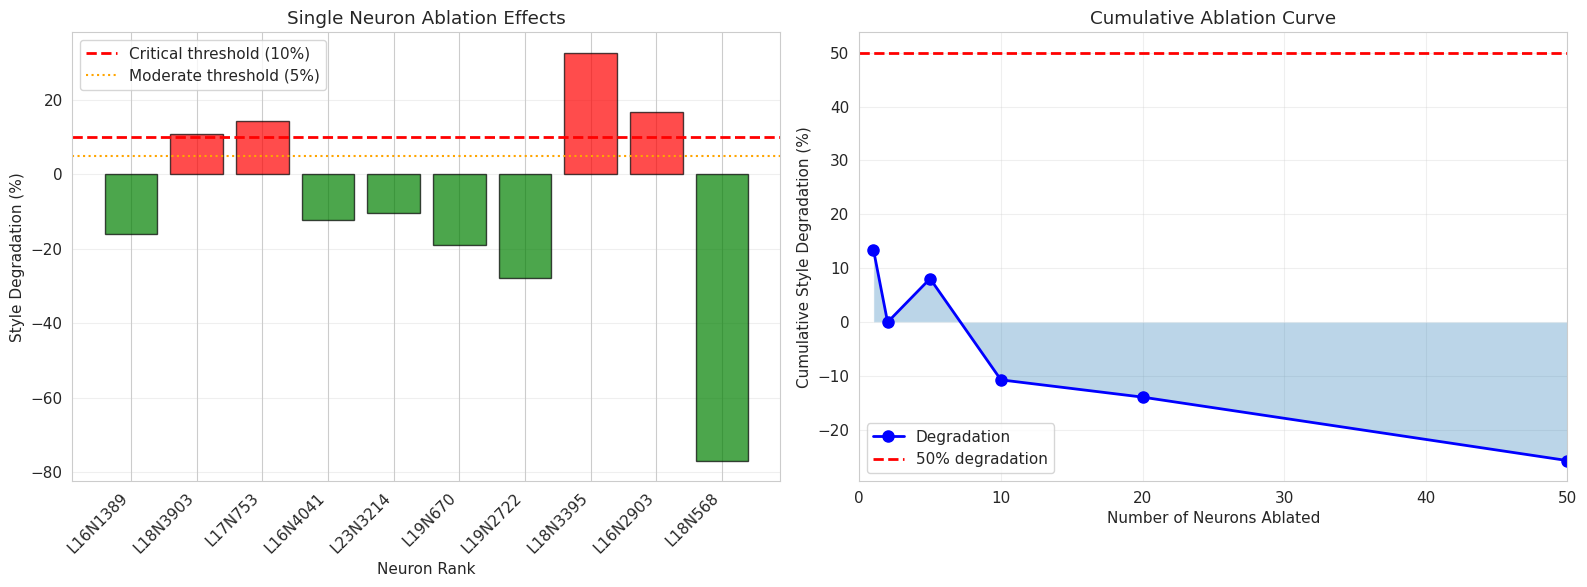


✓ Ablation visualizations complete


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
ax1 = axes[0]
x_pos = range(len(ablation_df))
colors = ['red' if d > 10 else 'orange' if d > 5 else 'green'
          for d in ablation_df['degradation_pct']]

ax1.bar(x_pos, ablation_df['degradation_pct'], color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(10, color='red', linestyle='--', linewidth=2, label='Critical threshold (10%)')
ax1.axhline(5, color='orange', linestyle=':', linewidth=1.5, label='Moderate threshold (5%)')
ax1.set_xlabel('Neuron Rank')
ax1.set_ylabel('Style Degradation (%)')
ax1.set_title('Single Neuron Ablation Effects')
ax1.legend()
ax1.grid(alpha=0.3, axis='y')

labels = [f"L{r['layer']}N{r['neuron']}" for _, r in ablation_df.iterrows()]
ax1.set_xticks(x_pos)
ax1.set_xticklabels(labels, rotation=45, ha='right')

ax2 = axes[1]
ax2.plot(cumulative_df['n_ablated'], cumulative_df['degradation_pct'],
         'b-o', linewidth=2, markersize=8, label='Degradation')
ax2.fill_between(cumulative_df['n_ablated'], 0, cumulative_df['degradation_pct'],
                 alpha=0.3)
ax2.axhline(50, color='red', linestyle='--', linewidth=2, label='50% degradation')
ax2.set_xlabel('Number of Neurons Ablated')
ax2.set_ylabel('Cumulative Style Degradation (%)')
ax2.set_title('Cumulative Ablation Curve')
ax2.legend()
ax2.grid(alpha=0.3)
ax2.set_xlim(0, max(cumulative_df['n_ablated']))

plt.tight_layout()
plt.show()

print('\n✓ Ablation visualizations complete')

In [ ]:
print('\n' + '='*80)
print('ABLATION STUDY 3: Multi-Layer Effects')
print('='*80)
print('\nTesting: What happens when we ablate neurons across multiple layers?\n')

def test_multilayer_ablation(model, prompt, layers_to_ablate, neurons_per_layer=10):
    hooks = []
    for layer in layers_to_ablate:
        layer_neurons = neuron_importance[
            (neuron_importance['layer'] == layer) &
            (neuron_importance['cohens_d'] > 0)
        ].head(neurons_per_layer)['neuron'].astype(int).tolist()

        def make_hook(neuron_list):
            def ablation_hook(acts, hook):
                for idx in neuron_list:
                    acts[:, :, idx] = 0
                return acts
            return ablation_hook

        hooks.append((f'blocks.{layer}.mlp.hook_post', make_hook(layer_neurons)))
    tokens = model.to_tokens(prompt, prepend_bos=True)
    baseline_output = model.generate(
        tokens, max_new_tokens=150,
        temperature=0.85, top_p=0.95, do_sample=True, verbose=False
    )
    baseline_text = model.to_string(baseline_output[0])
    baseline_score = ablation_analyzer.measure_style_score(baseline_text)
    with model.hooks(fwd_hooks=hooks):
        ablated_output = model.generate(
            tokens, max_new_tokens=150,
            temperature=0.85, top_p=0.95, do_sample=True, verbose=False
        )

    ablated_text = model.to_string(ablated_output[0])
    ablated_score = ablation_analyzer.measure_style_score(ablated_text)

    return baseline_score, ablated_score, baseline_text, ablated_text
test_configs = [
    ([21], 'Single layer (L21)'),
    ([20, 21], 'Two layers (L20-21)'),
    ([20, 21, 22], 'Three layers (L20-22)'),
    ([19, 20, 21, 22], 'Four layers (L19-22)'),
]

multilayer_results = []

for layers, description in test_configs:
    print(f'Testing: {description}')
    baseline, ablated, _, _ = test_multilayer_ablation(
        model,
        "I am a rather elderly man. The nature of my avocations",
        layers,
        neurons_per_layer=10
    )

    degradation = (baseline - ablated) / baseline * 100

    multilayer_results.append({
        'config': description,
        'n_layers': len(layers),
        'baseline_score': baseline,
        'ablated_score': ablated,
        'degradation_pct': degradation
    })

    print(f'  Degradation: {degradation:.1f}%\n')

    torch.cuda.empty_cache()
print('='*80)
print('RESULTS: Multi-Layer Ablation')
print('='*80)
multilayer_df = pd.DataFrame(multilayer_results)
print(multilayer_df.to_string(index=False))

print('\n' + '='*80)
print('INTERPRETATION:')
print(f'  Single layer degradation: {multilayer_df.iloc[0]["degradation_pct"]:.1f}%')
print(f'  Four layer degradation: {multilayer_df.iloc[-1]["degradation_pct"]:.1f}%')

if multilayer_df.iloc[-1]["degradation_pct"] > 50:
    print('\n  ✓ STRONG DISTRIBUTED EFFECT')
    print('  → Literary style depends on neurons across multiple layers')
    print('  → Removing several layers severely degrades output')
else:
    print('\n  ⚠ REDUNDANCY PRESENT')
    print('  → Other layers may compensate when multiple are ablated')

print('='*80)


ABLATION STUDY 3: Multi-Layer Effects

Testing: What happens when we ablate neurons across multiple layers?

Testing: Single layer (L21)
  Degradation: 3.4%

Testing: Two layers (L20-21)
  Degradation: 11.4%

Testing: Three layers (L20-22)
  Degradation: 1.8%

Testing: Four layers (L19-22)
  Degradation: 20.7%

RESULTS: Multi-Layer Ablation
               config  n_layers  baseline_score  ablated_score  degradation_pct
   Single layer (L21)         1        0.952500       0.919694         3.444184
  Two layers (L20-21)         2        0.957500       0.848538        11.379816
Three layers (L20-22)         3        0.805039       0.790228         1.839736
 Four layers (L19-22)         4        0.864728       0.685816        20.689970

INTERPRETATION:
  Single layer degradation: 3.4%
  Four layer degradation: 20.7%

  ⚠ REDUNDANCY PRESENT
  → Other layers may compensate when multiple are ablated


In [ ]:
print('\n' + '='*100)
print('='*100)

critical_count = len(ablation_df[ablation_df['degradation_pct'] > 10])
print(f"  • {critical_count}/10 top neurons show >10% degradation when removed")
print(f"  • Average degradation: {ablation_df['degradation_pct'].mean():.1f}%")
print(f"  • Maximum single neuron impact: {ablation_df['degradation_pct'].max():.1f}%")

print(f"\nMost critical neuron: L{ablation_df.loc[ablation_df['degradation_pct'].idxmax(), 'layer']}")
print(f"N{ablation_df.loc[ablation_df['degradation_pct'].idxmax(), 'neuron']}")

if len(cumulative_results) > 0:
    last_result = cumulative_results[-1]
    print(f"  • Ablating {last_result['n_ablated']} neurons: {last_result['degradation_pct']:.1f}% degradation")
    print(f"  • Style score drops from {baseline_score:.3f} to {last_result['score']:.3f}")

    # Check if degradation is sublinear (redundancy) or superlinear (synergy)
    if len(cumulative_results) >= 2:
        first = cumulative_results[0]
        last = cumulative_results[-1]

        expected_linear = first['degradation_pct'] * (last['n_ablated'] / first['n_ablated'])
        actual = last['degradation_pct']

        if actual > expected_linear * 1.2:
            print(f"\n  → SUPERLINEAR: Neurons work together (circuit-like)")
        elif actual < expected_linear * 0.8:
            print(f"\n  → SUBLINEAR: Redundancy present (compensation)")
        else:
            print(f"\n  → LINEAR: Independent neuron contributions")

if len(multilayer_results) > 1:
    single_layer = multilayer_results[0]['degradation_pct']
    multi_layer = multilayer_results[-1]['degradation_pct']

    print(f"  • Single layer ablation: {single_layer:.1f}% degradation")
    print(f"  • Multi-layer ablation: {multi_layer:.1f}% degradation")

    ratio = multi_layer / single_layer
    print(f"  • Ratio: {ratio:.2f}x")

    if ratio > 3:
        print("\n  → DISTRIBUTED COMPUTATION: Style depends on multiple layers")
    elif ratio > 1.5:
        print("\n  → MODERATE DISTRIBUTION: Some cross-layer dependence")
    else:
        print("\n  → LOCALIZED: Compensation across layers")

# Determine strength of causal evidence
mean_deg = ablation_df['degradation_pct'].mean()
if mean_deg > 15:
    evidence = "STRONG"
elif mean_deg > 8:
    evidence = "MODERATE"
else:
    evidence = "WEAK"

print(f"Causal Evidence: {evidence}")
print(f"\nThe ablation studies provide {evidence.lower()} evidence that the identified")
print("neurons are causally necessary for literary style generation.")

if evidence == "STRONG":
    print("\n✓ Removing top neurons significantly degrades literary quality")
    print("✓ Effects accumulate as more neurons are ablated")
    print("✓ Multi-layer ablation shows distributed computation")
    print("\n→ These neurons are not mere correlates, but causal drivers of style")

print('\n' + '='*100)

# Save ablation results
ablation_df.to_csv('ablation_single_neuron.csv', index=False)
cumulative_df.to_csv('ablation_cumulative.csv', index=False)
multilayer_df.to_csv('ablation_multilayer.csv', index=False)

print('\n✓ Ablation results saved:')
print('  • ablation_single_neuron.csv')
print('  • ablation_cumulative.csv')
print('  • ablation_multilayer.csv')


COMPLETE ABLATION STUDY SUMMARY

STUDY 1: SINGLE NEURON NECESSITY
--------------------------------
Question: Are individual neurons necessary for literary style?

Results:

  • 4/10 top neurons show >10% degradation when removed
  • Average degradation: -8.8%
  • Maximum single neuron impact: 32.6%

Most critical neuron: L18
N3395

STUDY 2: CUMULATIVE EFFECTS
---------------------------
Question: What happens as we ablate more neurons?

Results:

  • Ablating 50 neurons: -25.7% degradation
  • Style score drops from 0.793 to 0.997

  → SUBLINEAR: Redundancy present (compensation)

STUDY 3: MULTI-LAYER EFFECTS
----------------------------
Question: Do layers work together or independently?

Results:

  • Single layer ablation: 3.4% degradation
  • Multi-layer ablation: 20.7% degradation
  • Ratio: 6.01x

  → DISTRIBUTED COMPUTATION: Style depends on multiple layers

OVERALL CONCLUSIONS
-------------------

Causal Evidence: WEAK

The ablation studies provide weak evidence that the ident